#### Bayesian optimization for minimizing a 2D function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

In [2]:
class BayesianKernelRegression2D:
    def __init__(self, num_points=30, num_x_test=50, debug=False, random_seed=42, lcb_k=1.0):
        np.random.seed(random_seed)

        self.debug = debug  # Toggle printing
        self.lcb_k = lcb_k  # Weight for LCB

        # Initialize parameters as class attributes
        self.num_points = num_points  # Original data points
        self.num_x_test = num_x_test  # Number of x_test per dimension
        self.sigma_d_true = 0.2  # True standard deviation of noise in measured y
        self.sigma_d = 0.1  # Guessed standard deviation of noise in measured y
        self.sigma_k = 1  # Kernel
        self.sigma_theta = 0.5  # Prior of theta
        self.learning_rate = 0.00001
        self.iterations = 10000
        self.num_samples_metropolis = 100  # For Metropolis
        self.step_size = 6e-3
        self.threshold = 1e-10  # For removing small eigenvectors
        self.num_samples_mc = 5  # Number of samples in MC approximation

        self.x_l = -np.pi  # Lower end of x
        self.x_h = np.pi   # Higher end of x

        # Data
        # (self.num_points, 2) is size of output, first col is x_1, second col is x_2
        self.x = np.random.uniform(self.x_l, self.x_h, (self.num_points, 2))
        self.y = self.create_function(self.x)

        # x_test grid for 2D
        x1_test = np.linspace(self.x_l, self.x_h, self.num_x_test)
        x2_test = np.linspace(self.x_l, self.x_h, self.num_x_test)
        x1_test, x2_test = np.meshgrid(x1_test, x2_test)

        # 2D test points
        # .ravel() flatten row by row, that is, scan all columns in first row before moving to next
        # x1_test.ravel() is a 1d array of shape (num_x_test * num_x_test)
        # So the whole thing would give self.x_test of shape (num_x_test * num_x_test, 2)
        # first col is x_1, second col is x_2, same as self.x
        self.x_test = np.column_stack((x1_test.ravel(), x2_test.ravel()))

    # Create function
    def create_function(self, x, noiseless=False):
        y = np.sin(x[:, 0]) * np.sin(x[:, 1])  # True underlying 2d function
        if not noiseless:
            y += np.random.normal(0, self.sigma_d_true, size=x.shape[0])
        return y

    # Kernel
    def rbf_kernel_vectorized(self, x_set_1, x_set_2):
        # Number of points in each set
        num_points_1 = x_set_1.shape[0]
        num_points_2 = x_set_2.shape[0]

        # Calculate each point squared
        x1_sq_norms = np.sum(x_set_1 ** 2, axis=1).reshape(num_points_1, 1)  # Shape (num_points_1, 1)
        x2_sq_norms = np.sum(x_set_2 ** 2, axis=1).reshape(1, num_points_2)  # Shape (1, num_points_2)

        # Compute pairwise squared Euclidean distances
        sq_dists = x1_sq_norms + x2_sq_norms - 2 * np.dot(x_set_1, x_set_2.T)  # Shape (num_points_1, num_points_2)

        # Compute kernel
        k_mat = np.exp(-sq_dists / (2 * self.sigma_k ** 2))

        return k_mat

    # Virtual samples for original x, same as 1d
    def generate_virtual_samples_train(self):
        self.x_k = self.rbf_kernel_vectorized(self.x, self.x)
        eigenvalues, eigenvectors = np.linalg.eigh(self.x_k)
        if self.debug:
            print(f'raw eigenvalues: {eigenvalues.shape}')
            print(f'raw eigenvectors: {eigenvectors.shape}')

        mask = eigenvalues > self.threshold
        self.eigenvalues = eigenvalues[mask]
        self.eigenvectors = eigenvectors[:, mask]
        self.v_samples_train = self.eigenvectors @ np.diag(np.sqrt(self.eigenvalues))
        if self.debug:
            print(f'eigenvalues after thresholding (if needed): {self.eigenvalues.shape}')
            print(f'eigenvectors after thresholding (if needed): {self.eigenvectors.shape}')
            print(f'x_k: {self.x_k.shape}\n{self.x_k[:5, :5]}')
            print(f'v_samples_train @ v_samples_train.T: \n{(self.v_samples_train @ self.v_samples_train.T)[:5, :5]}')
            print(f'virtual samples shape: {self.v_samples_train.shape}')
            print()

    # Virtual samples for x_test, same as 1d
    def generate_virtual_samples_test(self):
        self.x_k_test = self.rbf_kernel_vectorized(self.x_test, self.x)
        self.v_samples_test = self.x_k_test @ self.eigenvectors @ np.diag(1 / np.sqrt(self.eigenvalues))
        if self.debug:
            print(f'v_samples_test shape: {self.v_samples_test.shape}')
            print(f'x_k_test[-5:,-5:]: \n {self.x_k_test[-5:, -5:]}')
            print(f'(v_samples_test@v_samples_train.T)[-5:,-5:]: \n{(self.v_samples_test @ self.v_samples_train.T)[-5:, -5:]}')
            print()

    # Gradient descent, MAP or ML, same as 1d
    def gradient_descent(self):
        theta = np.zeros(self.v_samples_train.shape[1])
        for k in range(self.iterations):
            y_pred = self.v_samples_train @ theta
            prior_theta = np.mean(theta**2) / self.sigma_theta**2
            likelihood = np.mean((y_pred - self.y)**2) / self.sigma_d**2
            loss = prior_theta + likelihood

            grad_prior_theta = theta / self.sigma_theta**2
            grad_likelihood = self.v_samples_train.T @ (y_pred - self.y) / self.sigma_d**2
            grad_loss = grad_prior_theta + grad_likelihood
            theta -= self.learning_rate * grad_loss

            if self.debug and k % (self.iterations // 10) == 0:
                print(f"Iteration {k}: loss = {loss:.4f}")

        if self.debug:
            print(f"MAP estimate of parameters: {theta}")
            print()
        return theta

    # Compute probability to evaluate whether to accept new theta in Metroplis, same as 1d
    def posterior(self, theta):
        # Posterior p(theta|D) is proportional to prior p(theta) times likelihood p(D|theta)
        y_pred = self.v_samples_train @ theta
        prior = np.exp(-0.5 * np.sum(theta**2) / self.sigma_theta**2)
        likelihood = np.exp(-0.5 * np.sum((y_pred - self.y)**2) / self.sigma_d**2)
        return prior * likelihood

    # Metropolis, same as 1d
    def metropolis(self, theta_init):
        samples = []
        theta_current = theta_init
        accepted = 0

        # Evaluate probability of current theta
        posterior_current = self.posterior(theta_current)

        # Compute covariance matrix based on step size, to select next theta
        proposal_cov = np.eye(theta_current.shape[0]) * self.step_size

        for _ in range(self.num_samples_metropolis):
            # Get new theta using Gaussian distribution
            theta_proposal = np.random.multivariate_normal(theta_current, proposal_cov)
            # Compute probability of new theta
            posterior_proposal = self.posterior(theta_proposal)
            # Compute ratio between new and old
            acceptance_prob = posterior_proposal / posterior_current
            # Determine acceptance
            if np.random.rand() < acceptance_prob:
                accepted += 1
                theta_current = theta_proposal
                posterior_current = posterior_proposal
            # Add to sample list
            samples.append(theta_current)

        self.theta_samples = np.array(samples)
        acceptance_rate = accepted / self.num_samples_metropolis
        print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

        if self.debug:
            print(f'Metropolis samples shape: {self.theta_samples.shape}')
            print()

    # MC approximation
    def compute_posterior_numerical_vectorized(self):

        # Vectorize computation of prediction means at all v_samples_test (row) for all thetas from metropolis (col)
        y_pred_mean_mat = self.v_samples_test @ self.theta_samples.T

        num_test_points = y_pred_mean_mat.shape[0]  # Number of test points for which we are making predictions
        num_theta_samples = y_pred_mean_mat.shape[1]  # Number of theta samples from Metropolis, representing different plausible theta

        # Simultaneously generate samples from prediction distribution at all y_pred_mean_mat
        noise_samples = np.random.normal(
            loc=0,
            scale=self.sigma_d,
            size=(num_test_points, num_theta_samples, self.num_samples_mc)
        )

        # Reshape y_pred_mean_mat to match noise_samples for broadcasting
        y_pred_mean_mat_reshaped = y_pred_mean_mat.reshape(num_test_points, num_theta_samples, 1)

        # Broadcast
        predictive_samples = y_pred_mean_mat_reshaped + noise_samples

        # Reshape to aggregate, for each x_test, all samples corresponding to prediction distributions based on all thetas
        merged_predictive_samples = predictive_samples.reshape(num_test_points, -1)

        # Compute mean and variance over all aggregated samples for each test point
        posterior_mean_y = np.mean(merged_predictive_samples, axis=1)
        posterior_var_y = np.var(merged_predictive_samples, axis=1)

        # Calculate diagonal elements of kernel matrix for variance correction
        self.k_star_star_diag = np.ones(self.x_test.shape[0])  # Diagonal elements are 1 for RBF kernel

        # Compute diagonal of v_samples_test @ v_samples_test.T
        v_samples_diag = np.sum(self.v_samples_test**2, axis=1)

        # Correct posterior variance
        posterior_var_y_corrected = posterior_var_y - v_samples_diag + self.k_star_star_diag

        # Take square root to obtain standard deviation
        posterior_std_y = np.sqrt(posterior_var_y_corrected)

        return posterior_mean_y, posterior_std_y

    # Analytical solution for posterior mean and variance
    def analytical_solution(self, use_formula='2.12'):
        if use_formula == '2.12':
            # Compute posterior mean and covariance using kernel in original space, per eq. 2.12, in Rasmussen and Williams's Gaussian process book

            H_mat = self.x_k + np.eye(self.x_k.shape[0]) * self.sigma_d**2
            H_mat = (H_mat + H_mat.T) / 2  # Ensure symmetry
            H_mat += np.eye(H_mat.shape[0]) * 1e-6  # Numerical stability
            H_mat_inv = np.linalg.inv(H_mat)

            analytical_mean_y = self.x_k_test @ H_mat_inv @ self.y

            # Compute diagonal elements of x_k_test @ H_mat_inv @ x_k_test.T
            temp = self.x_k_test @ H_mat_inv  # Shape: (num_test, num_train)
            x_k_test_diag_product = np.sum(temp * self.x_k_test, axis=1)

            # Compute diagonal of covariance matrix
            cov_diag = self.k_star_star_diag - x_k_test_diag_product

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

        elif use_formula == '2.11':
            # Compute covariance using virtual sample in feature space, eq. 2.11
            A_mat = self.v_samples_train.T @ self.v_samples_train / self.sigma_d**2 + np.eye(self.v_samples_train.shape[1]) / self.sigma_theta**2

            A_mat = (A_mat + A_mat.T) / 2  # Ensure symmetry
            A_mat += np.eye(A_mat.shape[0]) * 1e-6  # Numerical stability
            A_mat_inv = np.linalg.inv(A_mat)

            mean_2 = 1 / self.sigma_d**2 * self.v_samples_test @ A_mat_inv @ self.v_samples_train.T @ self.y
            analytical_mean_y = mean_2

            # Compute diagonal elements of v_samples_test @ A_mat_inv @ v_samples_test.T
            temp = self.v_samples_test @ A_mat_inv  # Shape: (num_test, num_features)
            cov_diag_feature = np.sum(temp * self.v_samples_test, axis=1)

            # Compute diagonal elements of v_samples_test @ v_samples_test.T
            v_samples_diag = np.sum(self.v_samples_test**2, axis=1)

            # Correct posterior variance
            cov_diag = cov_diag_feature - v_samples_diag + self.k_star_star_diag

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

    # Compute lower confidence bound
    def lower_confidence_bound(self, mean, std):
        # Calculate LCB for minimization
        return mean - self.lcb_k * std

    # Compute next best x using LCB for Bayesian optimization, vectorized
    def compute_next_best_x_lcb_vectorized(self):
        # Compute LCB for all test points at once
        lcbs = self.lower_confidence_bound(self.posterior_mean_numerical, self.posterior_std_numerical)

        # Determine x_test with lowest LCB value
        next_best_x_index = np.argmin(lcbs)  # Get index of next best x
        next_best_x = self.x_test[next_best_x_index]  # Pull x value corresponding to that index

        return next_best_x

    # Plot results with 2D contour plots and slice plot
    def plot_results(self, next_best_point=None, iteration=None):
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Grid setup for plotting
        x1_test = self.x_test[:, 0].reshape(self.num_x_test, self.num_x_test)
        x2_test = self.x_test[:, 1].reshape(self.num_x_test, self.num_x_test)
        y_true = self.create_function(self.x_test, noiseless=True).reshape(self.num_x_test, self.num_x_test)
        if self.debug:
            print(f'x1_test: \n{x1_test[:5,:5]}')
            print(f'x2_test: \n{x2_test[:5,:5]}')
            print()

        # Find index where x2 is closest to pi/2
        index_closest_pi_half = np.argmin(np.abs(self.x_test[:, 1] - np.pi/2))
        x2_close_value = self.x_test[index_closest_pi_half, 1]  # Get the value of x2 at this index

        # Get all indices with this x2 value
        indices = np.where(self.x_test[:, 1] == x2_close_value)[0]
        x1_slice = self.x_test[indices, 0]
        if self.debug:
            print(f'x2_close_value: {x2_close_value}')
            print(f'x1_slice shape: {x1_slice.shape}')
            print()
        true_function_slice = self.create_function(self.x_test[indices], noiseless=True)  # Calculate true function values at the slice

        # First row: plots along slice
        # Fitted curves from Metropolis samples
        for sample in self.y_test_samples[indices].T:
            axes[0, 0].plot(x1_slice, sample, color='magenta', alpha=0.1)
        y_map = self.v_samples_test @ self.theta_map
        axes[0, 0].plot(x1_slice, y_map[indices], color='white', linestyle='-', label='MAP/ML estimate')
        axes[0, 0].set_title('Fitted curves at x_2 around pi/2')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.2)

        # Numerical
        mean_slice_num = self.posterior_mean_numerical[indices]
        std_slice_num = self.posterior_std_numerical[indices]
        axes[0, 1].plot(x1_slice, mean_slice_num, label='Numerical mean', color='cyan')
        axes[0, 1].fill_between(x1_slice, mean_slice_num - 2*std_slice_num, mean_slice_num + 2* std_slice_num, color='cyan', alpha=0.3, label='Std Dev')
        axes[0, 1].plot(x1_slice, true_function_slice,  color='orange', linestyle='--',label='True function', linewidth=2)
        axes[0, 1].set_title('Numerical prediction at x_2 around pi/2')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.2)

        # Analytical
        mean_slice_ana = self.posterior_mean_analytical[indices]
        std_slice_ana = self.posterior_std_analytical[indices]
        axes[0, 2].plot(x1_slice, mean_slice_ana, label='Analytical mean', color='red')
        axes[0, 2].fill_between(x1_slice, mean_slice_ana - 2*std_slice_ana, mean_slice_ana + 2*std_slice_ana, color='red', alpha=0.3, label='Std Dev')
        axes[0, 2].plot(x1_slice, true_function_slice, color='orange', linestyle='--', label='True function', linewidth=2)
        axes[0, 2].set_title('Analytical prediction at x_2 around pi/2')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.2)

        # Second row: contour plots
        contour = axes[1, 0].contourf(x1_test, x2_test, y_true, cmap='viridis', alpha=0.5)
        fig.colorbar(contour, ax=axes[1, 0])
        axes[1, 0].set_title('Underlying function')
        axes[1, 0].axhline(y=x2_close_value, color='white', linestyle='--')
        axes[1, 0].scatter(self.x[:, 0], self.x[:, 1], color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)

        contour = axes[1, 1].contourf(x1_test, x2_test, self.posterior_mean_numerical.reshape(self.num_x_test, self.num_x_test), cmap='viridis', alpha=0.5)
        fig.colorbar(contour, ax=axes[1, 1])
        if iteration is not None:
            axes[1, 1].set_title(f'Numerical (Iteration {iteration})')
        else:
            axes[1, 1].set_title('Numerical')
        axes[1, 1].scatter(self.x[:, 0], self.x[:, 1], color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)

        contour = axes[1, 2].contourf(x1_test, x2_test, self.posterior_mean_analytical.reshape(self.num_x_test, self.num_x_test), cmap='viridis', alpha=0.5)
        fig.colorbar(contour, ax=axes[1, 2])
        if iteration is not None:
            axes[1, 2].set_title(f'Analytical (Iteration {iteration})')
        else:
            axes[1, 2].set_title('Analytical')
        axes[1, 2].scatter(self.x[:, 0], self.x[:, 1], color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)

        if next_best_point is not None:
            next_best_x, new_y = next_best_point
            axes[1, 1].scatter(next_best_x[0], next_best_x[1], color='red', marker='x', s=125, label='New data point')
            axes[1, 2].scatter(next_best_x[0], next_best_x[1], color='red', marker='x', s=125, label='New data point')

        plt.tight_layout()
        plt.show()

    # Main method, fit data points, find next best x using LCB, add new x, y to data, plot, then repeat
    def main_bo_lcb(self, max_iterations=1, convergence_threshold=0.01):
        for iteration in range(max_iterations):
            # Generate virtual samples for original x

            self.generate_virtual_samples_train()

            # Gradient descent to obtain theta_map or theta_ml
            self.theta_map = self.gradient_descent()

            # Metropolis sampling of posterior distribution of theta
            self.metropolis(self.theta_map)

            # Generate virtual samples for x_test
            self.generate_virtual_samples_test()

            # Compute prediction corresponding to different theta sampled using Metropolis
            self.y_test_samples = self.v_samples_test @ self.theta_samples.T

            # Compute posterior mean and uncertainty using numerical and analytical methods
            self.posterior_mean_numerical, self.posterior_std_numerical = self.compute_posterior_numerical_vectorized()
            self.posterior_mean_analytical, self.posterior_std_analytical = self.analytical_solution()

            # Determine next best x using Lower Confidence Bound and get new y
            next_best_x = self.compute_next_best_x_lcb_vectorized()

            new_y = self.create_function(np.array([next_best_x]))[0]

            # Plot results
            self.plot_results(next_best_point=(next_best_x, new_y), iteration=iteration)

            # Add new x and y to dataset
            self.x = np.vstack((self.x, next_best_x))
            self.y = np.append(self.y, new_y)

            # Optional: Check for convergence based on iteration limit or other criteria
            if convergence_threshold is not None:
                if iteration > 0 and np.abs(self.y.min() - new_y) < convergence_threshold:
                    print(f"Convergence reached at iteration {iteration}")
                    break
            print()

Metropolis acceptance rate: 0.47


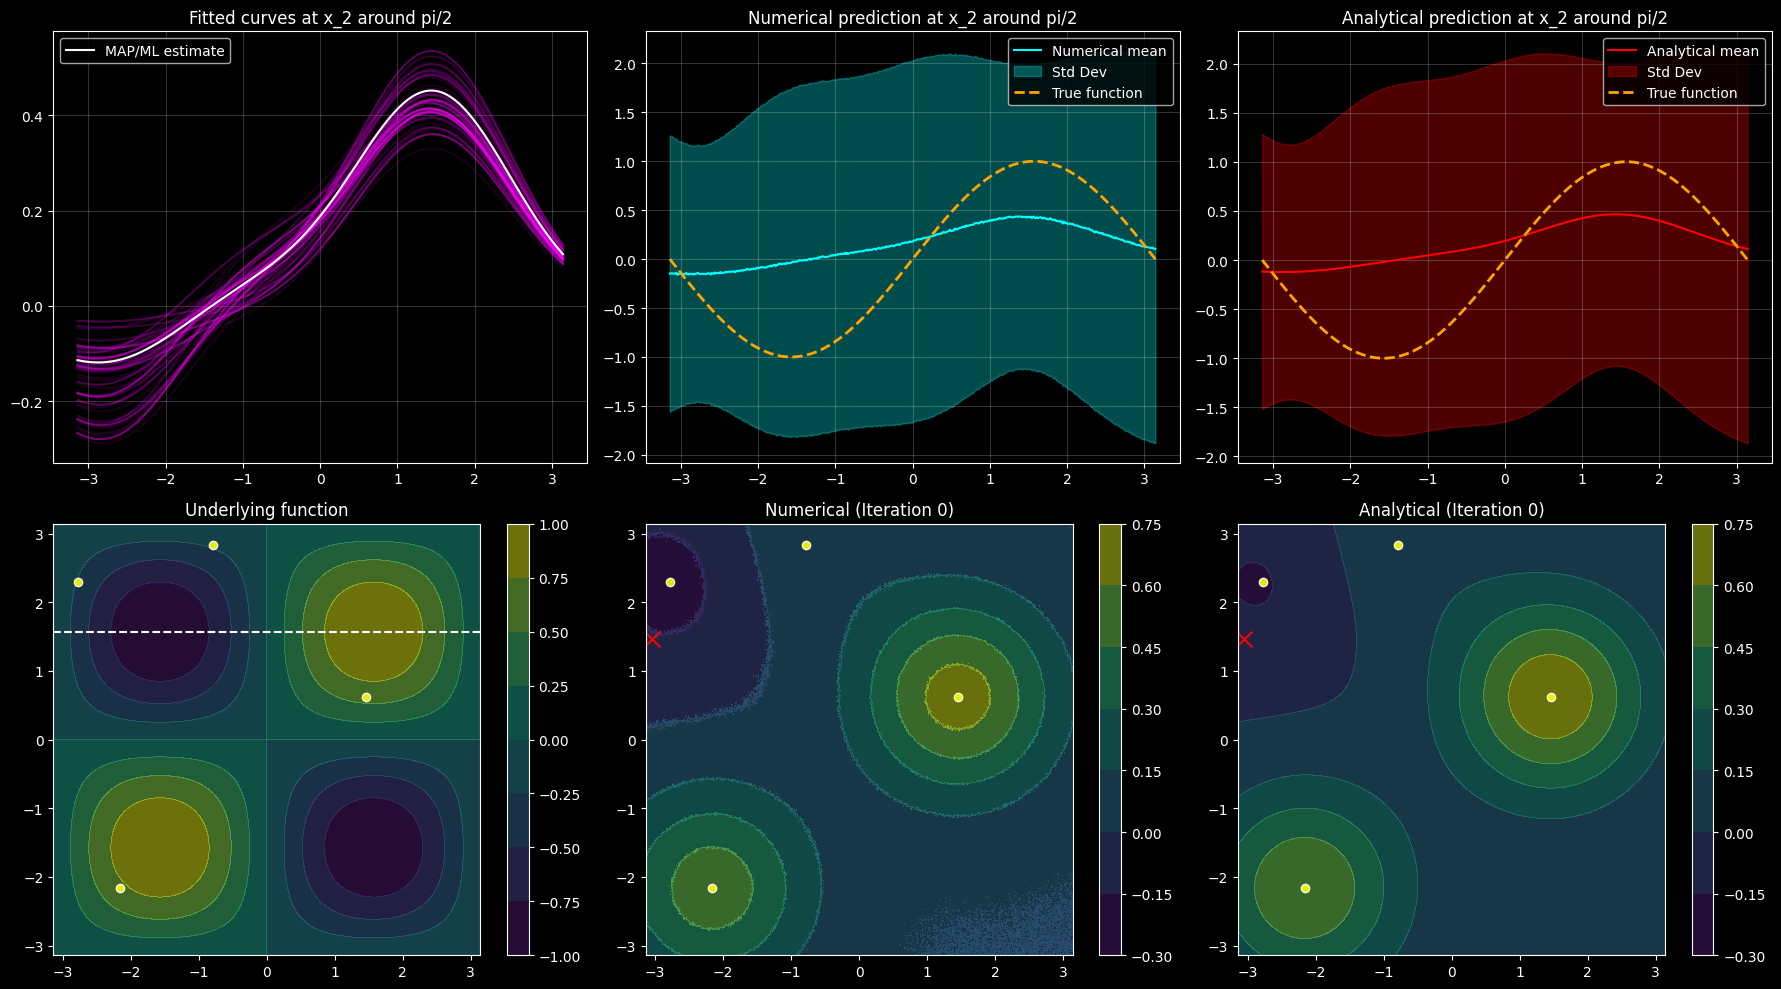


Metropolis acceptance rate: 0.43


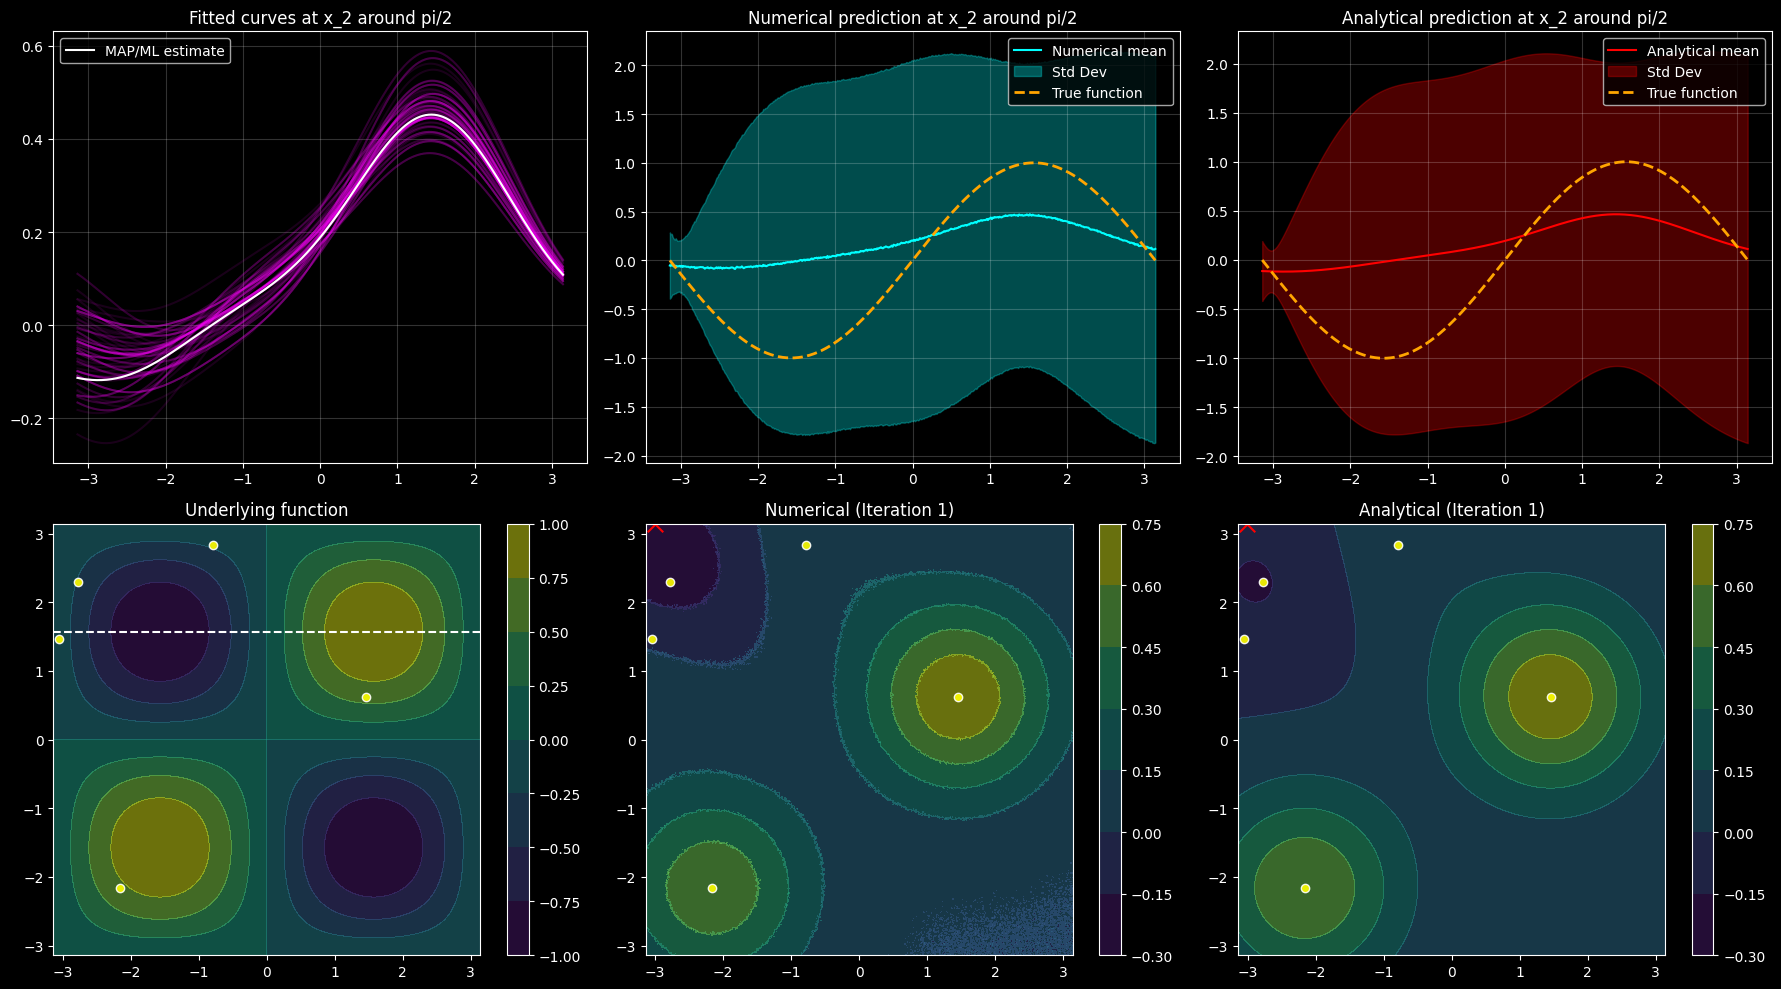


Metropolis acceptance rate: 0.40


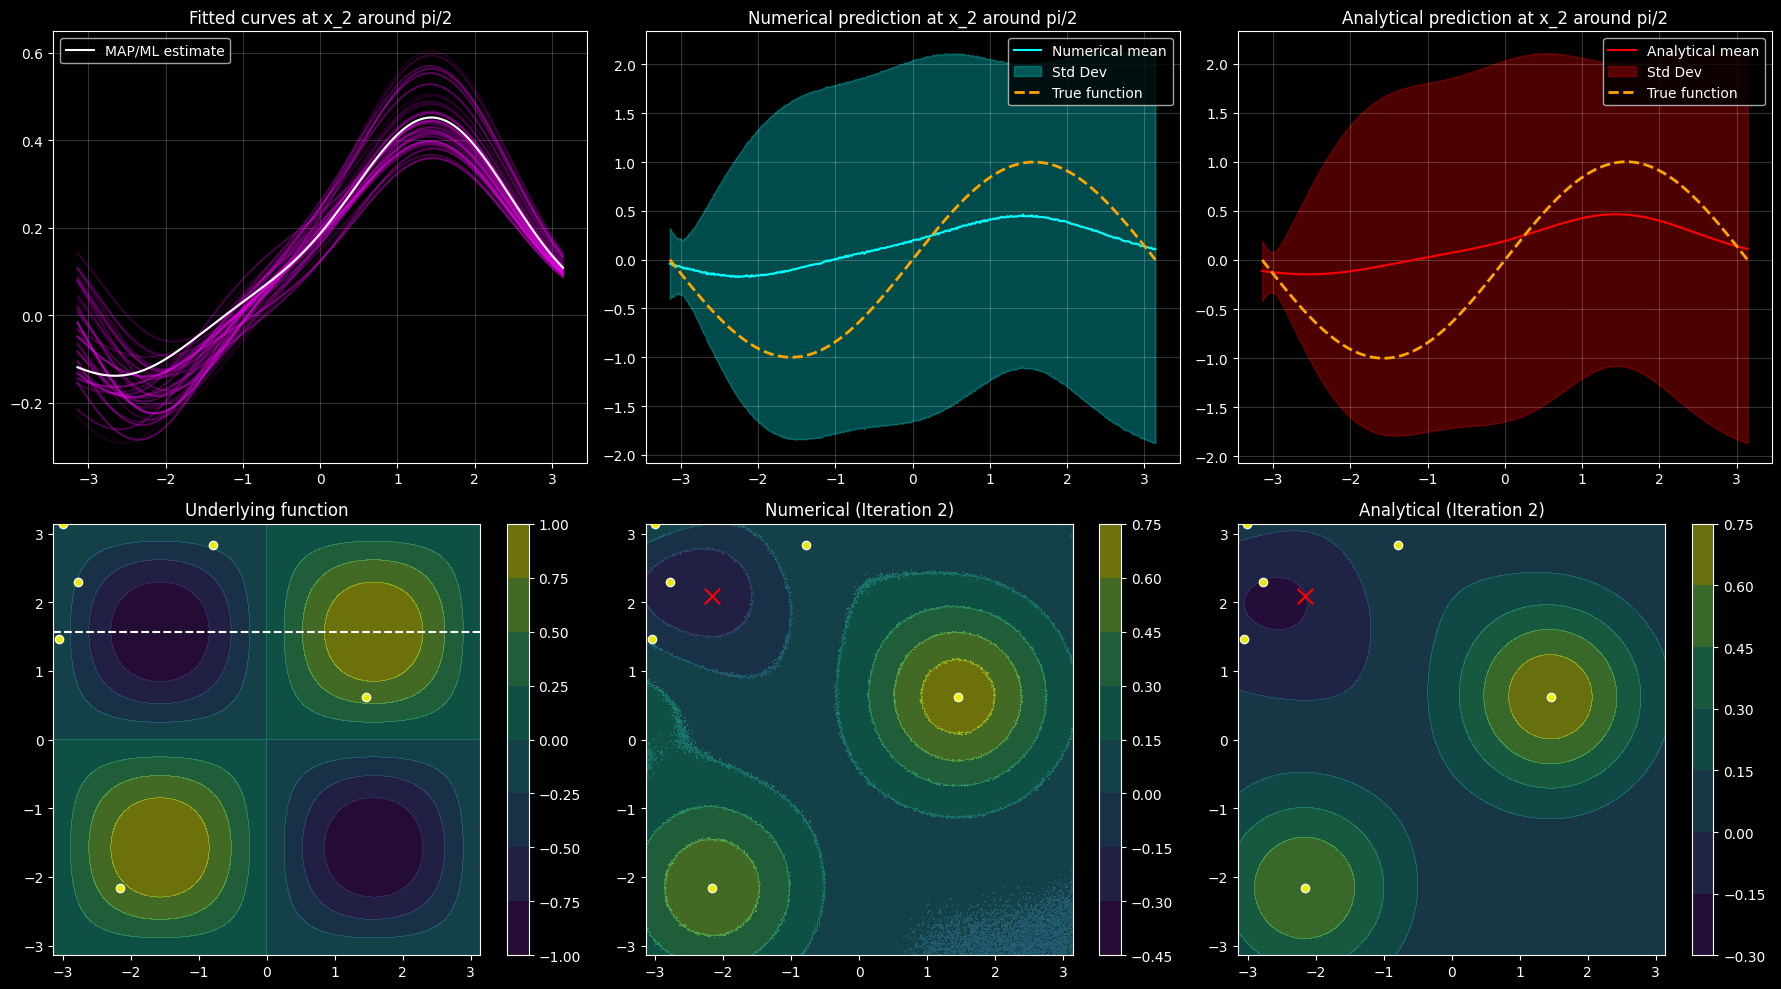


Metropolis acceptance rate: 0.29


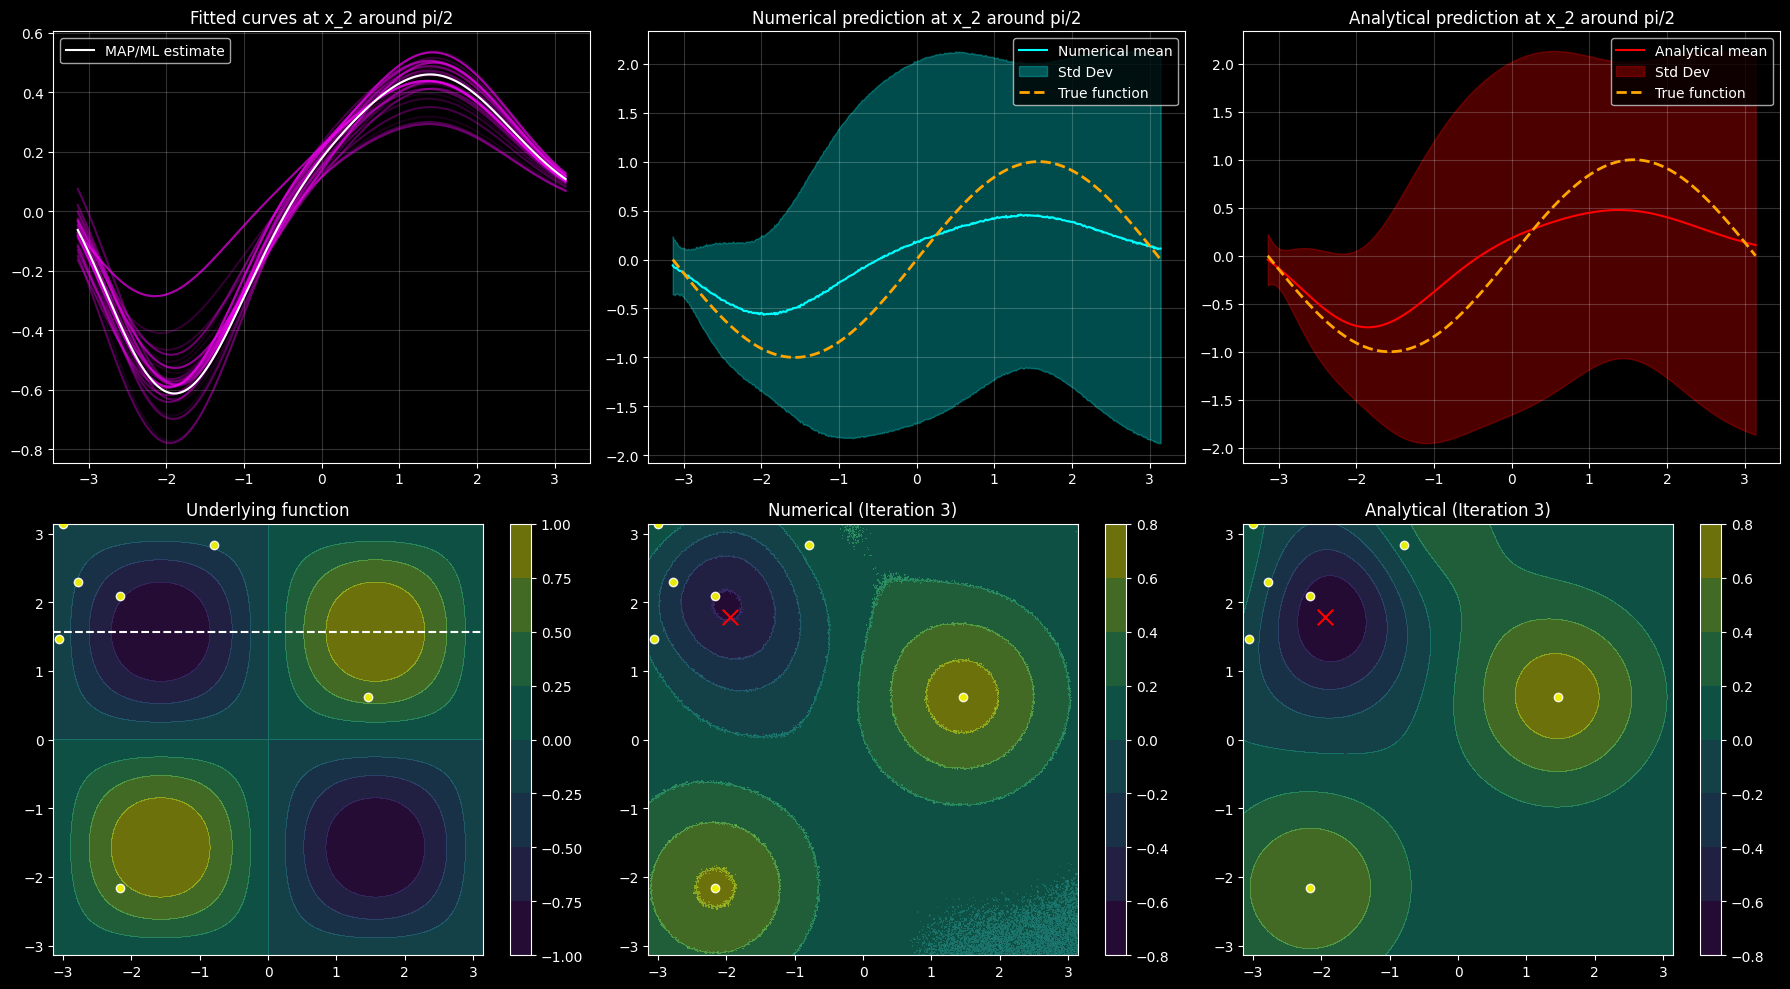


Metropolis acceptance rate: 0.26


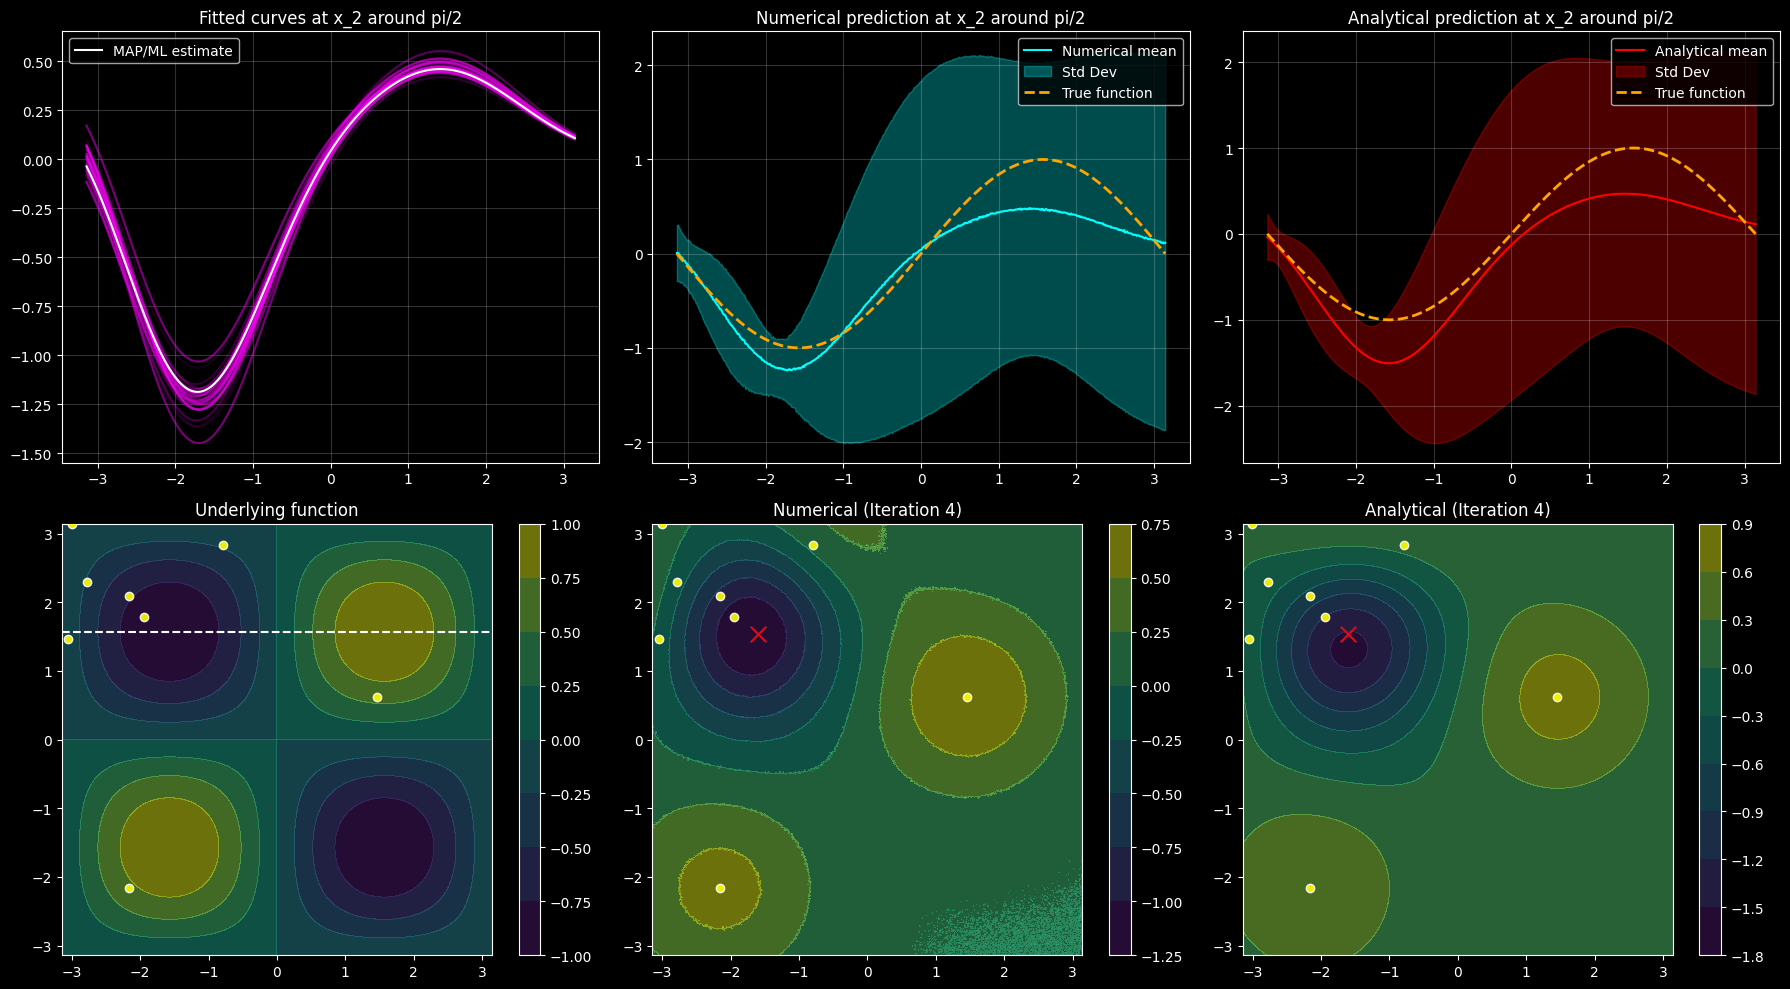


Metropolis acceptance rate: 0.20


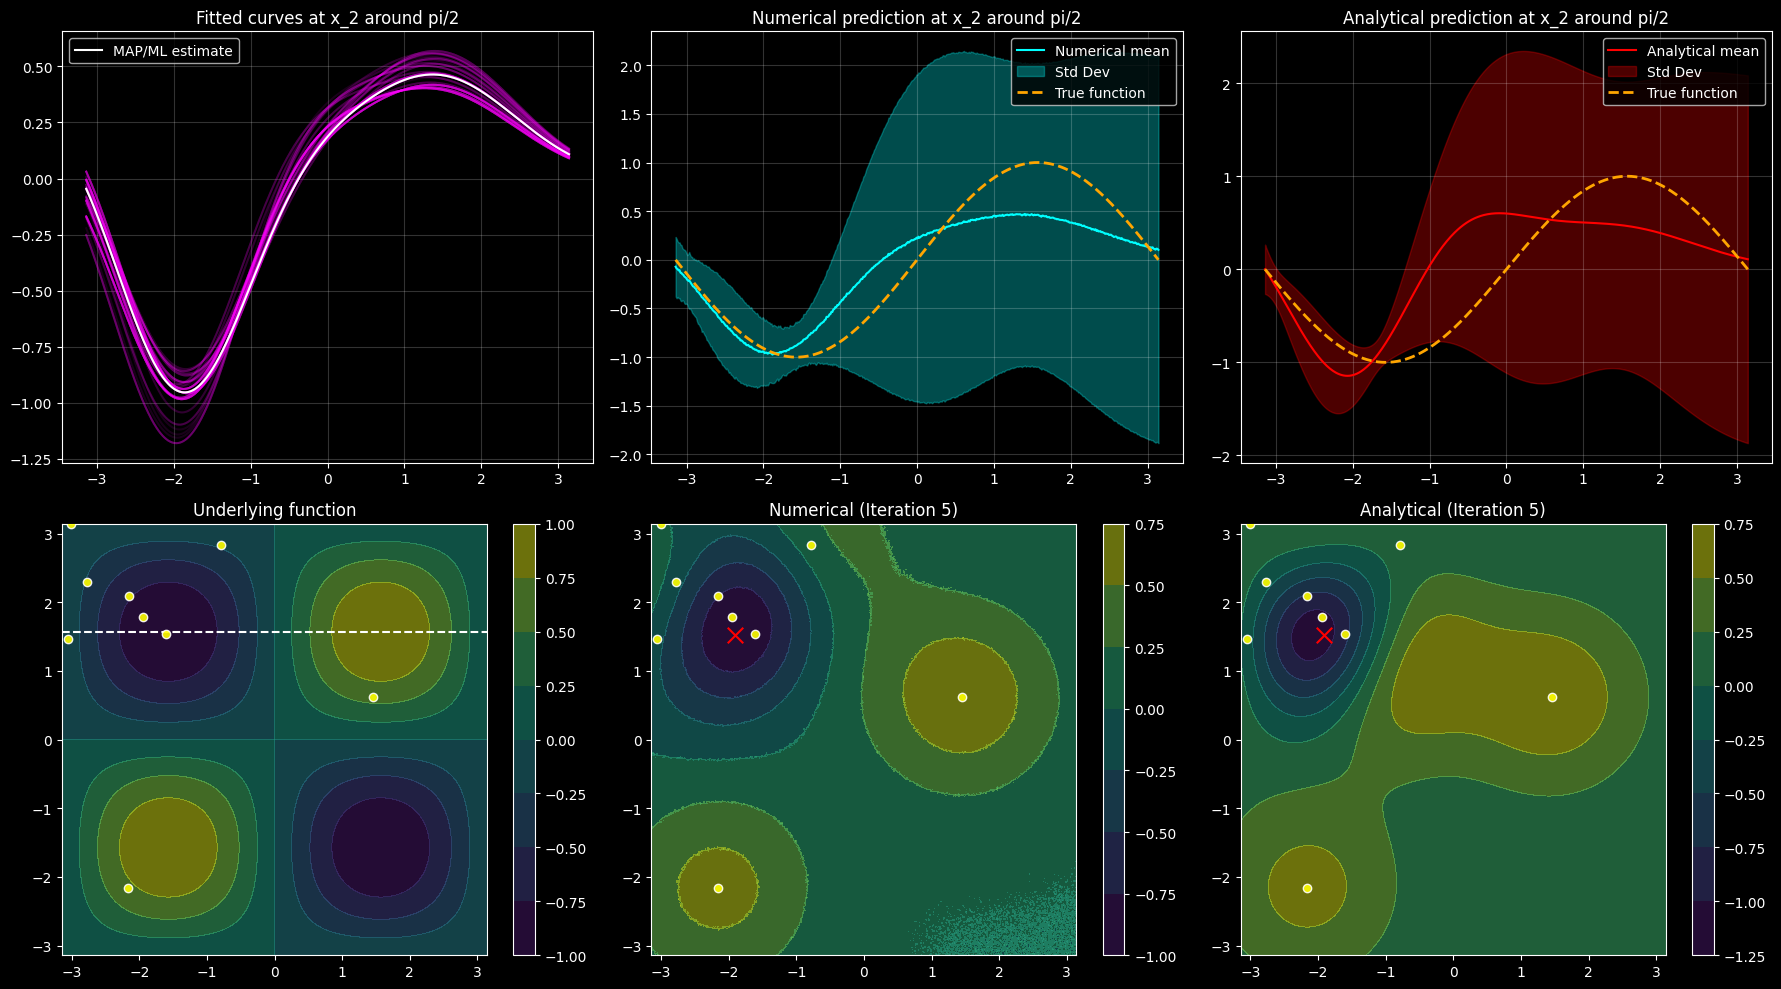


Metropolis acceptance rate: 0.18


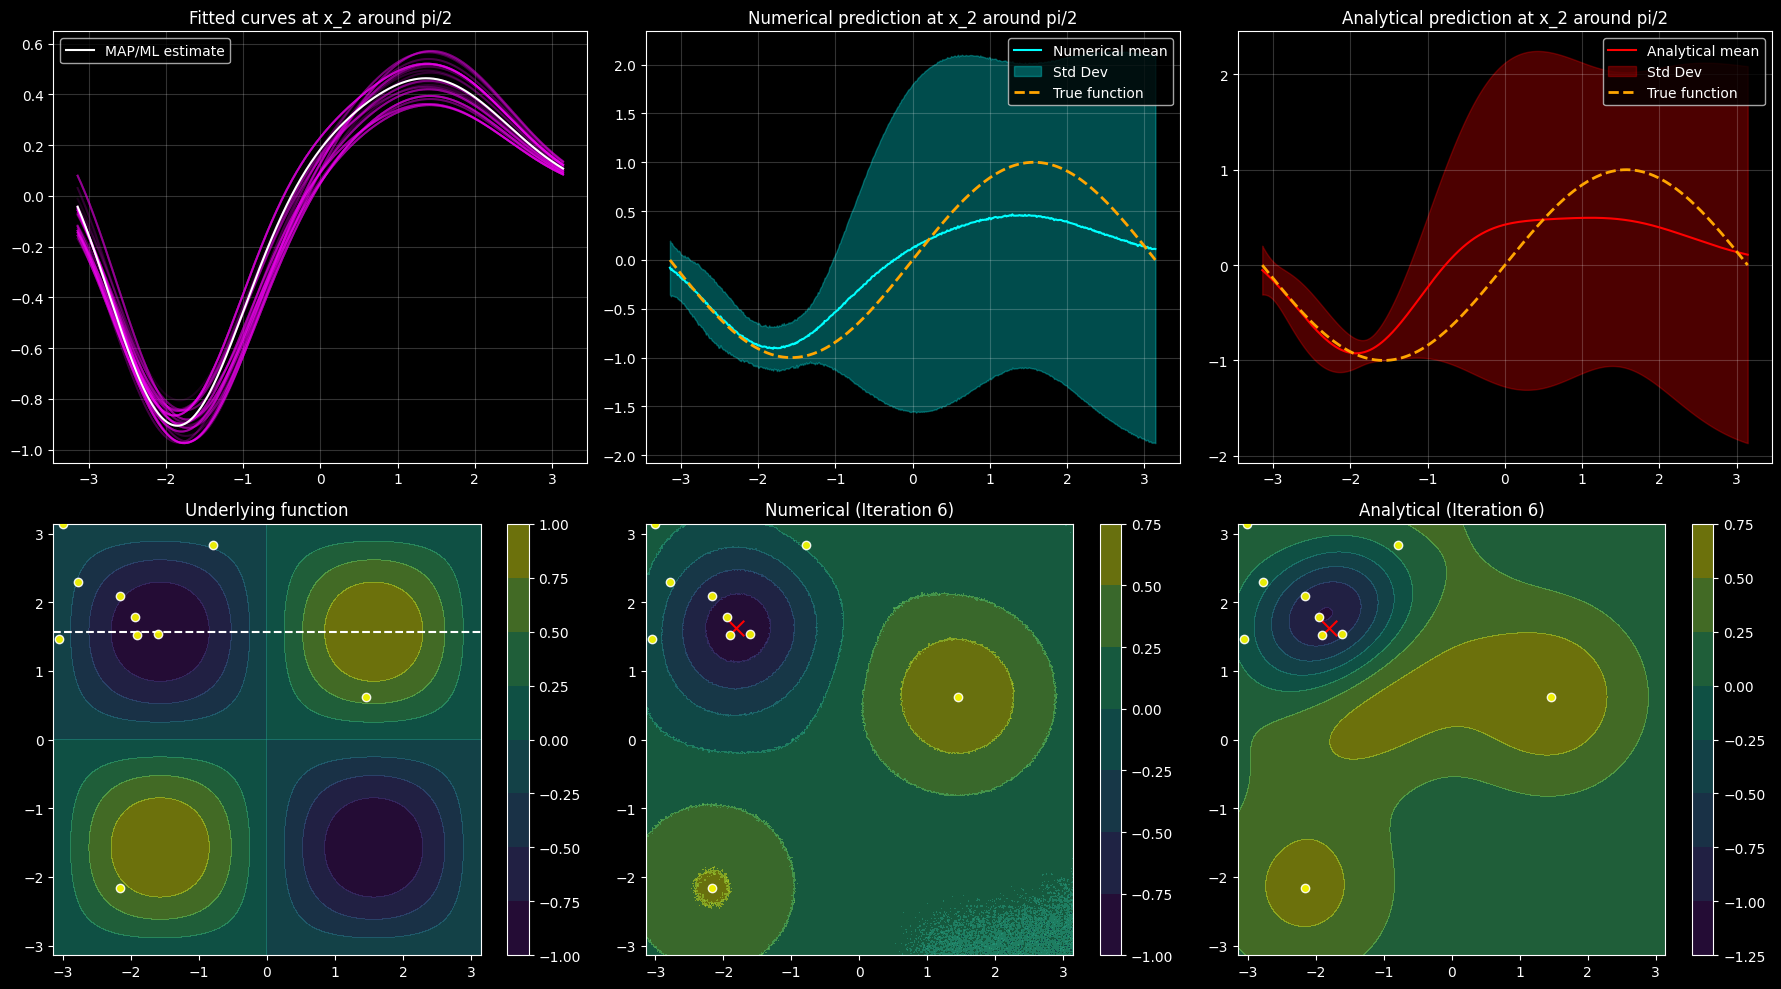


Metropolis acceptance rate: 0.25


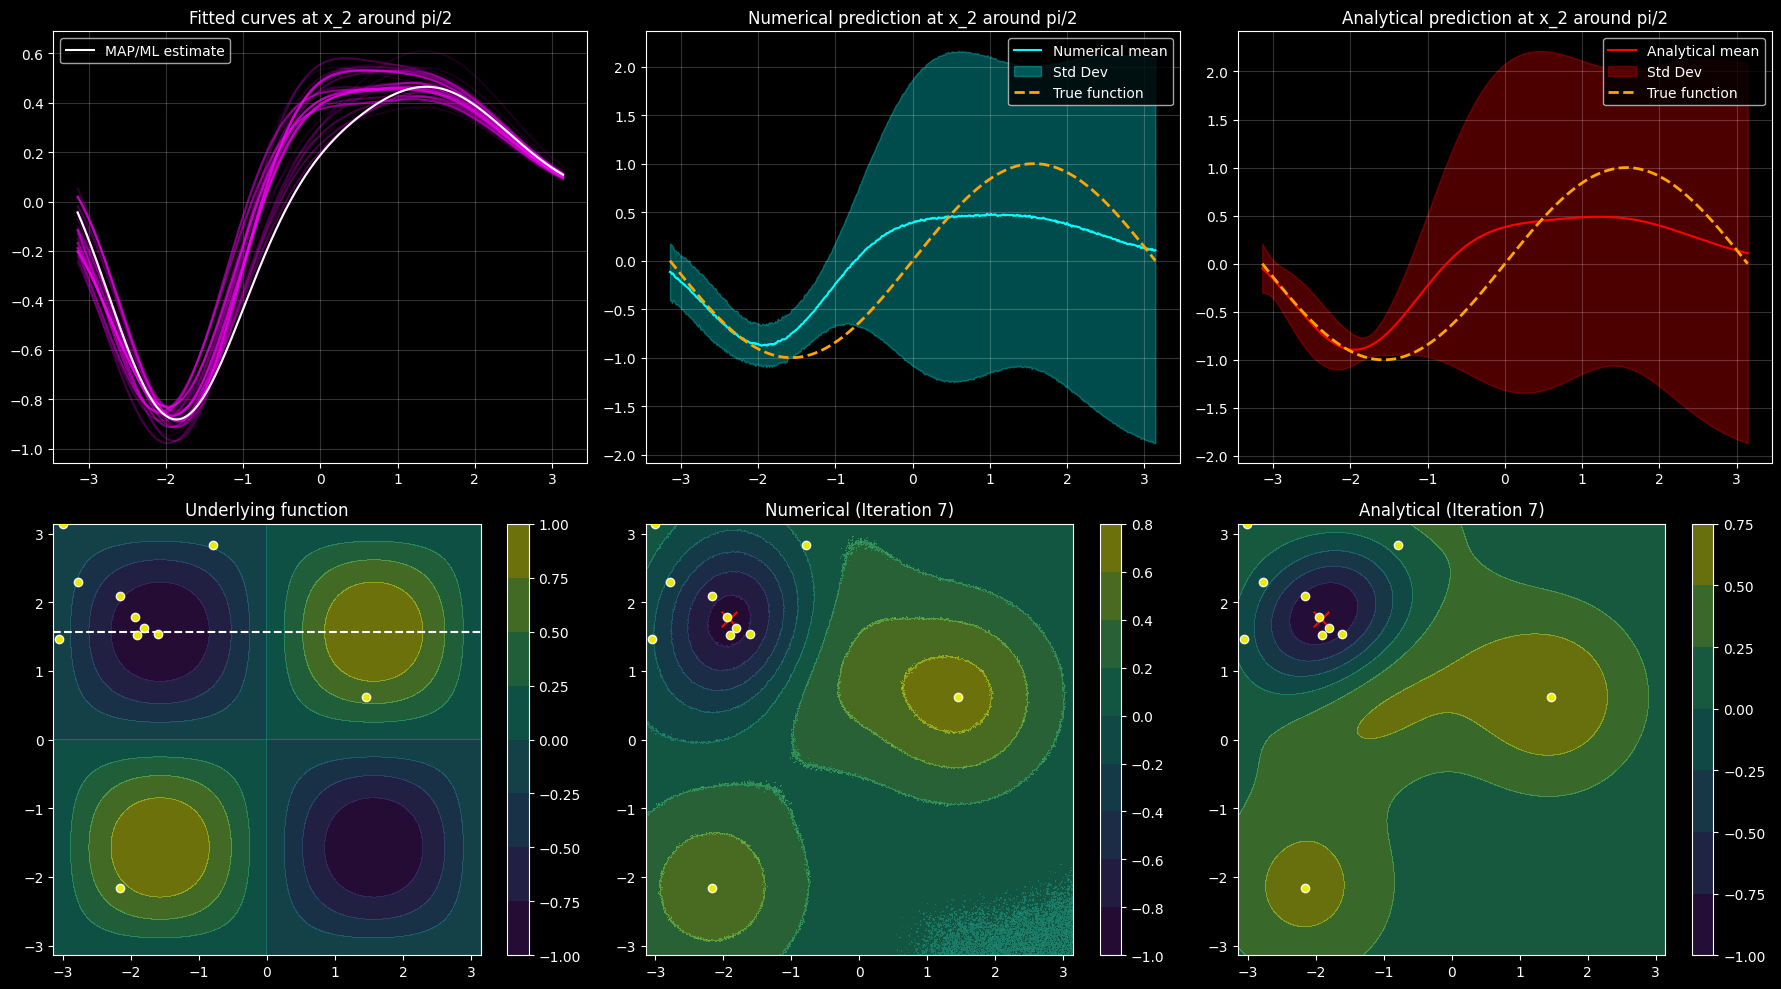


Metropolis acceptance rate: 0.31


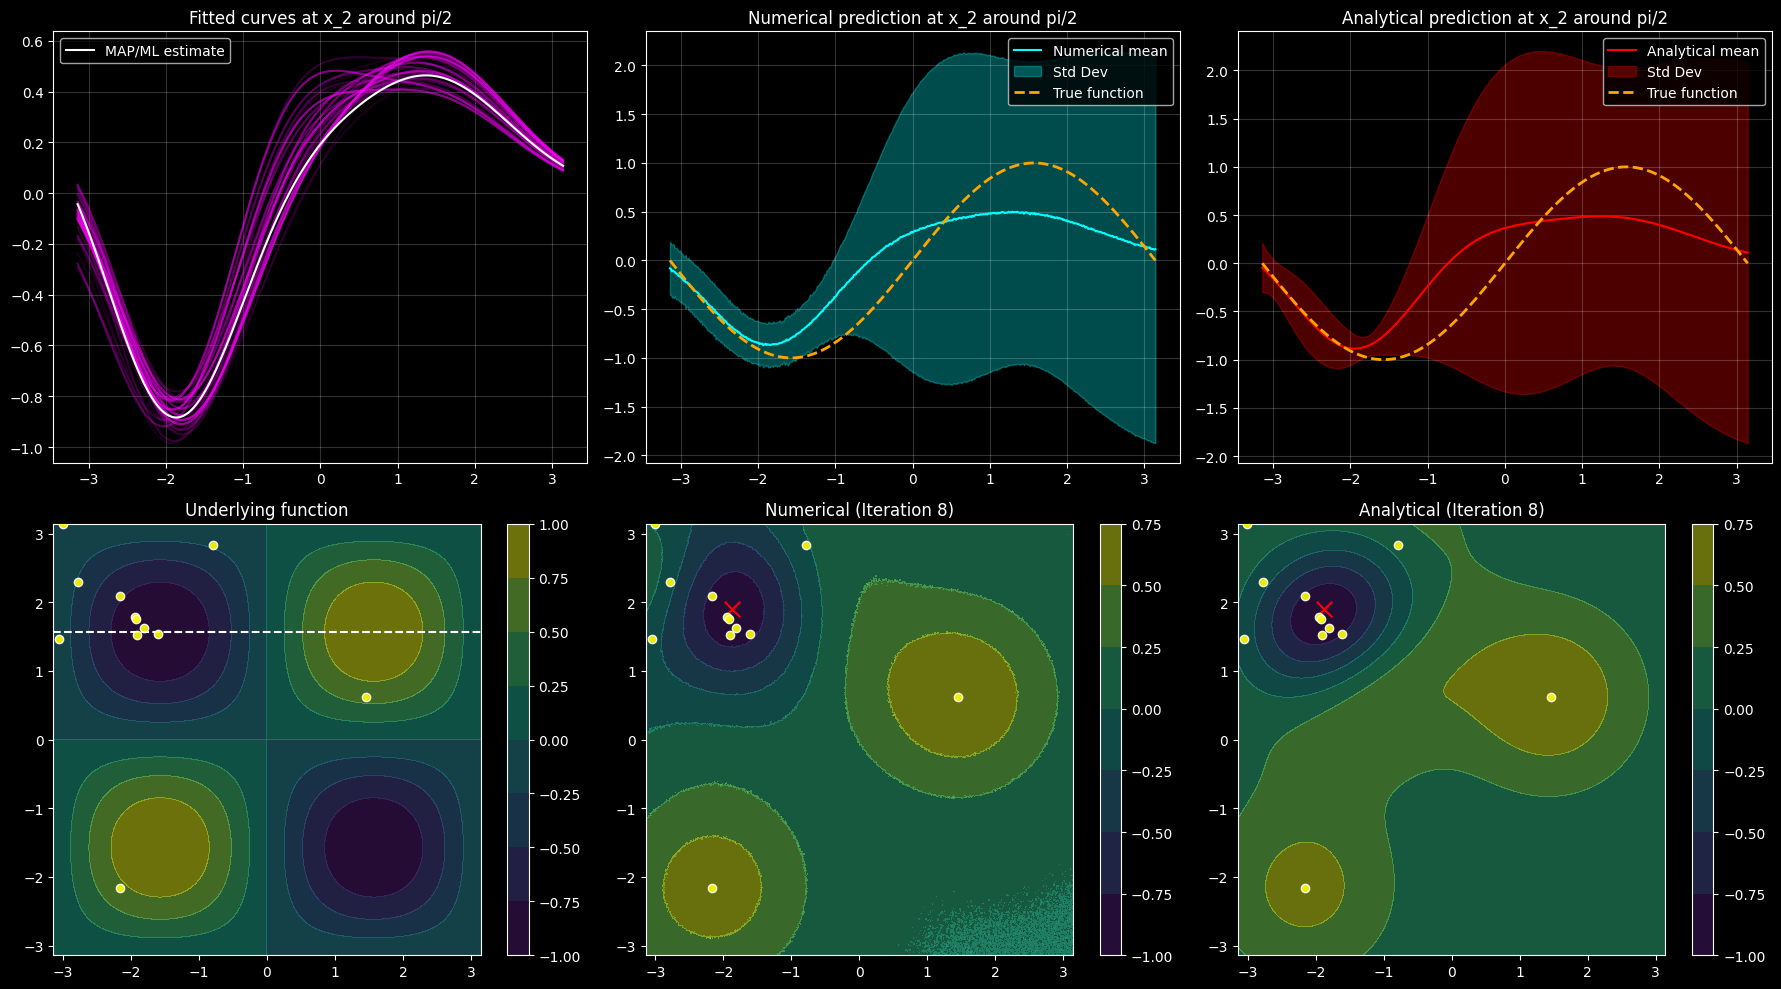


Metropolis acceptance rate: 0.17


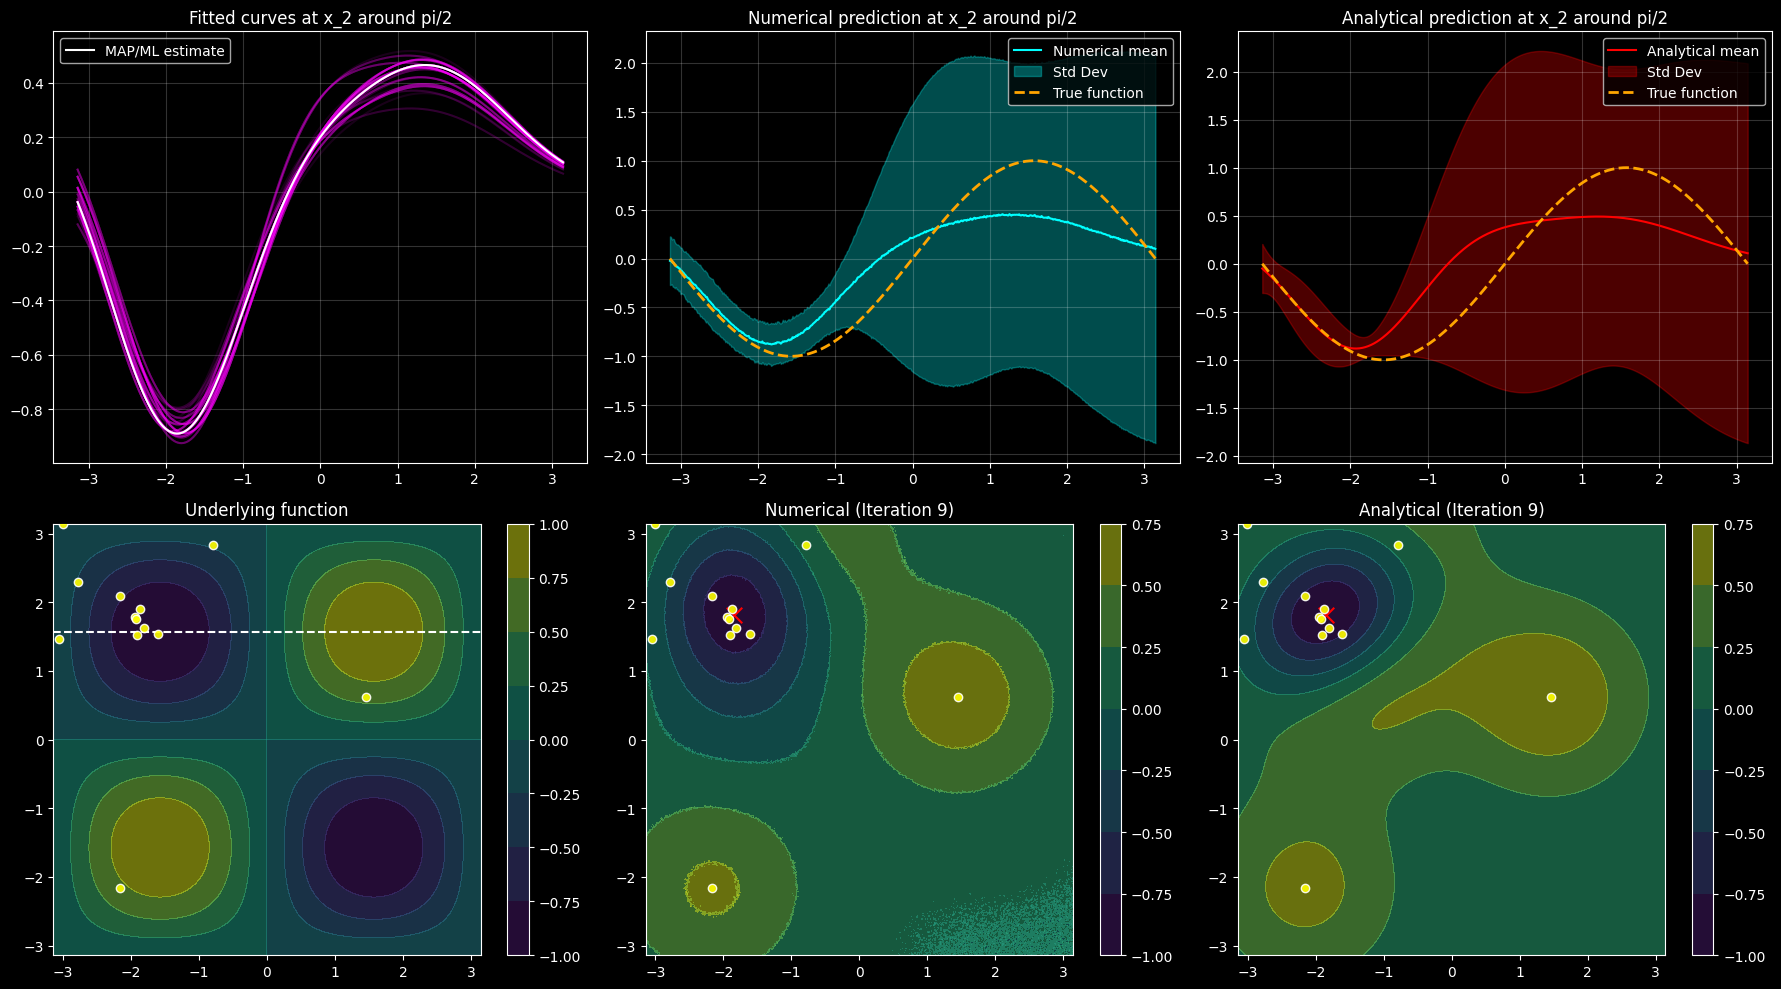

In [3]:
kernel_reg_2d = BayesianKernelRegression2D(num_points=4, num_x_test=500, debug=False, random_seed=42, lcb_k=0.2)
kernel_reg_2d.main_bo_lcb(max_iterations=10, convergence_threshold=None)